In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import fetch_openml
from scipy.signal import convolve2d
from copy import deepcopy
from sklearn.mixture import GaussianMixture as GMM
import cv2 as cv
import winsound as ws
import os


In [157]:
def train(n_samples, m, n):
    data = load_samples(mnist, n_samples=n_samples)
    train_data = extract_patch(data, m=m)
    gm = GMM(n_components = n, random_state = 0, warm_start=True, verbose=2).fit(train_data)
    return gm

def extract_patch(this, m=8):

    l, x, y = this.shape
    x = x - m + 1
    y = y - m + 1

    patches = np.zeros((l * x * y, m**2), dtype=np.float64)

    for n in range(l):
        for i in range(x):
            for j in range(y):
                patches[n * x * y + y * i + j, :] = this[n, i : i + m, j : j + m].reshape((m**2,))

    return patches


def load_images(path, idx=None):

    images = []

    if not os.path.isfile(f'./{path}'):
        files = [f'./{path}/{i}' for i in os.listdir(f'./{path}')]
    else : files = [path]

    for n, file in enumerate(files):
        if idx is None or n in idx:
            img = cv.imread(f'./{file}')
            img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
            images.append(img.astype(np.float64))

    return np.asarray(images)


def remake_image(patches, m, imgSize=28):

    n_patches = imgSize - m + 1
    a = np.eye(n_patches**2)
    a = a.reshape((n_patches**2, n_patches, n_patches))

    total   =   np.asarray([convolve2d(a[i, :, :], patches[i]) for i in range(n_patches**2)])
    total   =   np.sum(total, axis=0)
    weights =   np.asarray([convolve2d(a[i, :, :], np.ones((m,m))) for i in range(n_patches**2)])
    weights =   np.sum(weights, axis=0)

    return total / (weights + np.max(weights))


def load_samples(mnist, n_samples):

    myset = []

    data = np.asarray(mnist.data)
    labels = mnist.target.astype("int64").to_numpy()

    data = data.reshape((data.shape[0], 28, 28))

    l = np.zeros(10)

    for i, label in enumerate(labels):
        if label == np.argmin(l) :
            l[label] = l[label] + 1
            myset.append(i)
            if len(myset) == n_samples :
                break
    print('samples of each label:\n',l)

    return data[myset, :, :]

def Z_Y(gm, y, W, s, m, n):

    ####without posterior:
    # a = np.asarray(gm.means_[gm.predict(y)])
    # return a.T
    l = len(y)
    prec_Z = np.asarray(gm.precisions_)
    cov_Z = np.asarray(gm.covariances_)
    mu_Z = np.asarray(gm.means_)
    pi_Z = np.asarray(gm.weights_)

    prec_Y = np.eye(m**2) / s**2

    prec_ZY = prec_Z + W @ prec_Y @ W
    cov_ZY = np.linalg.inv(prec_ZY)

    mu_ZY = cov_ZY @ (np.tile((W @ prec_Y @ y.T), (n, 1, 1))) # + np.tile(cov_Z @ mu_Z[:, :, np.newaxis], (1, 1, l)

    return np.mean(mu_ZY,axis=0)

    ##what theoritical answer should be
    diff_to_mus = np.linalg.norm(np.tile(y.T, (n,1,1)) - mu_ZY, axis=1)

    MAP = np.log(pi_Z.reshape((n, 1))) - np.log(diff_to_mus)
    indexes = np.argmax(MAP, axis=0) 

    ans = np.zeros((m**2, l), dtype=np.float64)

    for i in range(l):
        ans[:, i] = mu_ZY[indexes[i], :, i]
    return ans

def beep():
    for i in range(6):
        ws.Beep(1000, 300)
        ws.Beep(2000, 300)


In [58]:
mnist = fetch_openml('mnist_784')


c:\Users\AmirH\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [59]:
n_samples = 100
ms      = [4, 8, 12, 16, 20, 28]
n = 20
gm_by_m = []

for i, m in enumerate(ms):

    gm = train(n_samples, m, n)
    gm_by_m.append(gm)



samples of each label:
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
Initialization 0
  Iteration 10	 time lapse 5.55445s	 ll change 3.58516
  Iteration 20	 time lapse 5.22639s	 ll change 0.01687
  Iteration 30	 time lapse 5.21581s	 ll change 0.01103
Initialization converged: True	 time lapse 20.19459s	 ll 34.12558
samples of each label:
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
Initialization 0
  Iteration 10	 time lapse 11.61702s	 ll change 2.11959
  Iteration 20	 time lapse 10.93294s	 ll change 0.63962
  Iteration 30	 time lapse 10.91118s	 ll change 0.22166
Initialization converged: True	 time lapse 42.20353s	 ll -44.31428
samples of each label:
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
Initialization 0
  Iteration 10	 time lapse 20.33368s	 ll change 4.28750
  Iteration 20	 time lapse 18.07711s	 ll change 0.24767
  Iteration 30	 time lapse 17.48880s	 ll change 0.03722
Initialization converged: True	 time lapse 61.13036s	 ll -340.19730
samples of each label:
 [10. 10. 10. 10. 10. 10. 

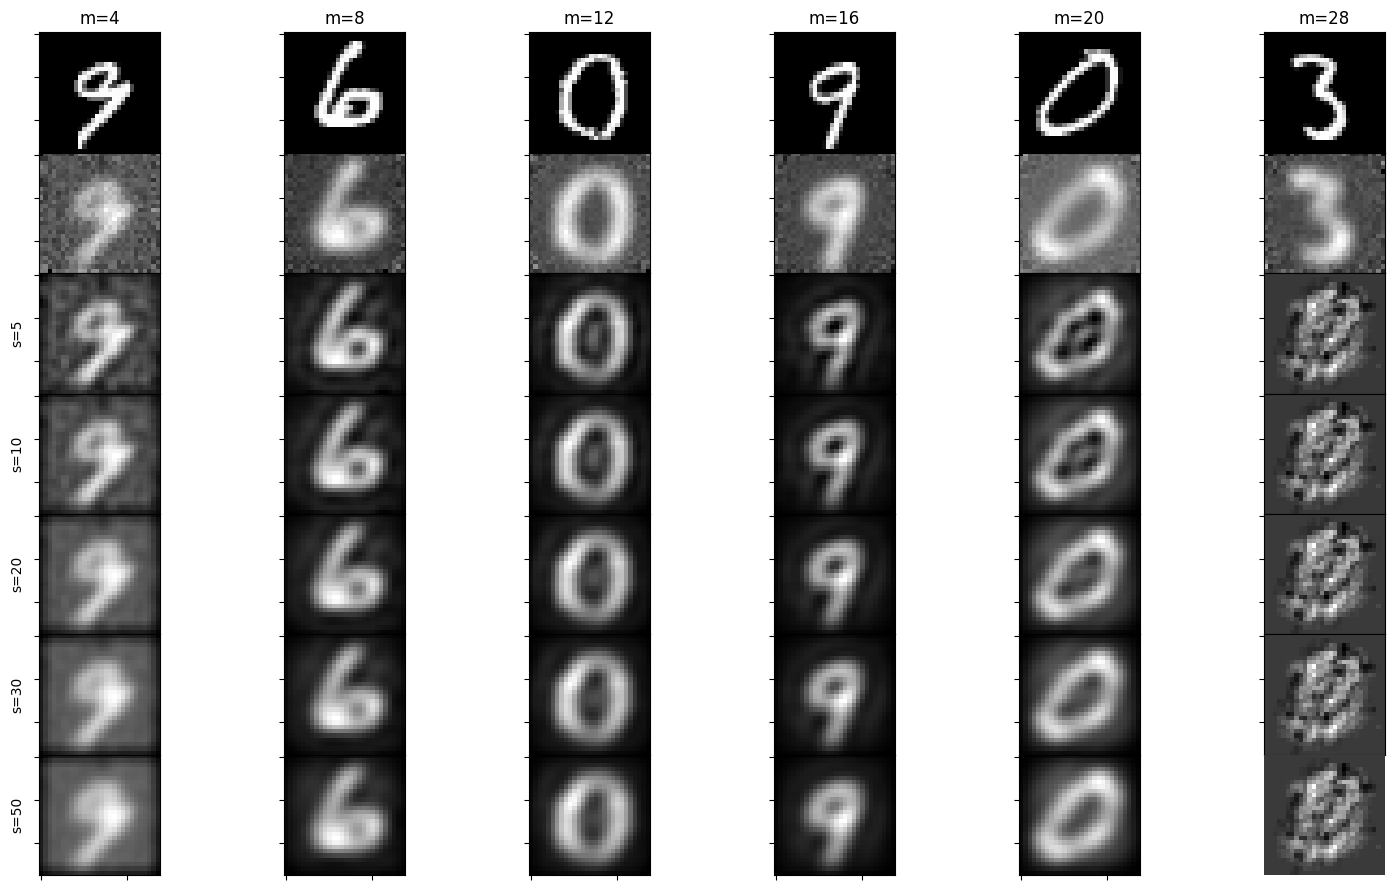

In [158]:
n_samples = 100
ms      = [4, 8, 12, 16, 20, 28]
sigs    = [5, 10, 20, 30, 50]
n_images = len(ms)
n = 20

fig, axes = plt.subplots(7, n_images, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(15,9))

for i, m in enumerate(ms):

    gm = gm_by_m[i]

    all_images = load_images(f'./Dataset/MNIST-m={m}/MNIST/corrupted/')
    all_originals = load_images(f'./Dataset/MNIST-m={m}/MNIST/original/')
    W = np.load(f'Dataset/MNIST-m={m}/MNIST/W.npy')

    idx = np.random.randint(0, len(all_images))
    image       =   all_images[idx, :, :]
    original    =   all_originals[idx, :, :]
    original /= np.max(original)

    axes[0, i].set_title(f'm={m}')
    axes[0, i].imshow(original, cmap='gray')
    axes[1, i].imshow(image, cmap='gray')

    test_data = extract_patch(image.reshape((1, 28, 28)), m=m)

    for k, sig in enumerate(sigs):

        try:
            mapResult   =  [res.reshape((m,m)) for res in Z_Y(gm, test_data, W, sig, m, n).T]
        except Exception:
            mapResult   =  [np.ones((m,m)) for i in range(len(test_data))]

        remaked_map = remake_image(mapResult, m)
        remaked_map = remaked_map / np.max(remaked_map)
        axes[2 + k, i].imshow(remaked_map, cmap='gray')

        if i == 0:
            axes[2 + k, i].set_ylabel(f's={sig}')


for i in axes.flatten():
    i.set_xticklabels([])
    i.set_yticklabels([])

fig.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()

In [61]:
n_samples = 200
n = 20

ms = [12, 16]
gm_by_m_accurate = []

for i, m in enumerate(ms):
    gm_by_m_accurate.append(train(n_samples, m, n))


samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 36.61362s	 ll change 4.61950
  Iteration 20	 time lapse 32.62466s	 ll change 0.73758
  Iteration 30	 time lapse 33.35568s	 ll change 0.04082
  Iteration 40	 time lapse 33.03447s	 ll change 0.09872
  Iteration 50	 time lapse 33.19227s	 ll change 0.07616
  Iteration 60	 time lapse 32.99885s	 ll change 0.20954
Initialization converged: True	 time lapse 231.54788s	 ll -294.80726
samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 44.81316s	 ll change 3.07756
  Iteration 20	 time lapse 42.81640s	 ll change 0.89503
  Iteration 30	 time lapse 41.12185s	 ll change 0.21946
Initialization converged: True	 time lapse 156.90876s	 ll -706.35004


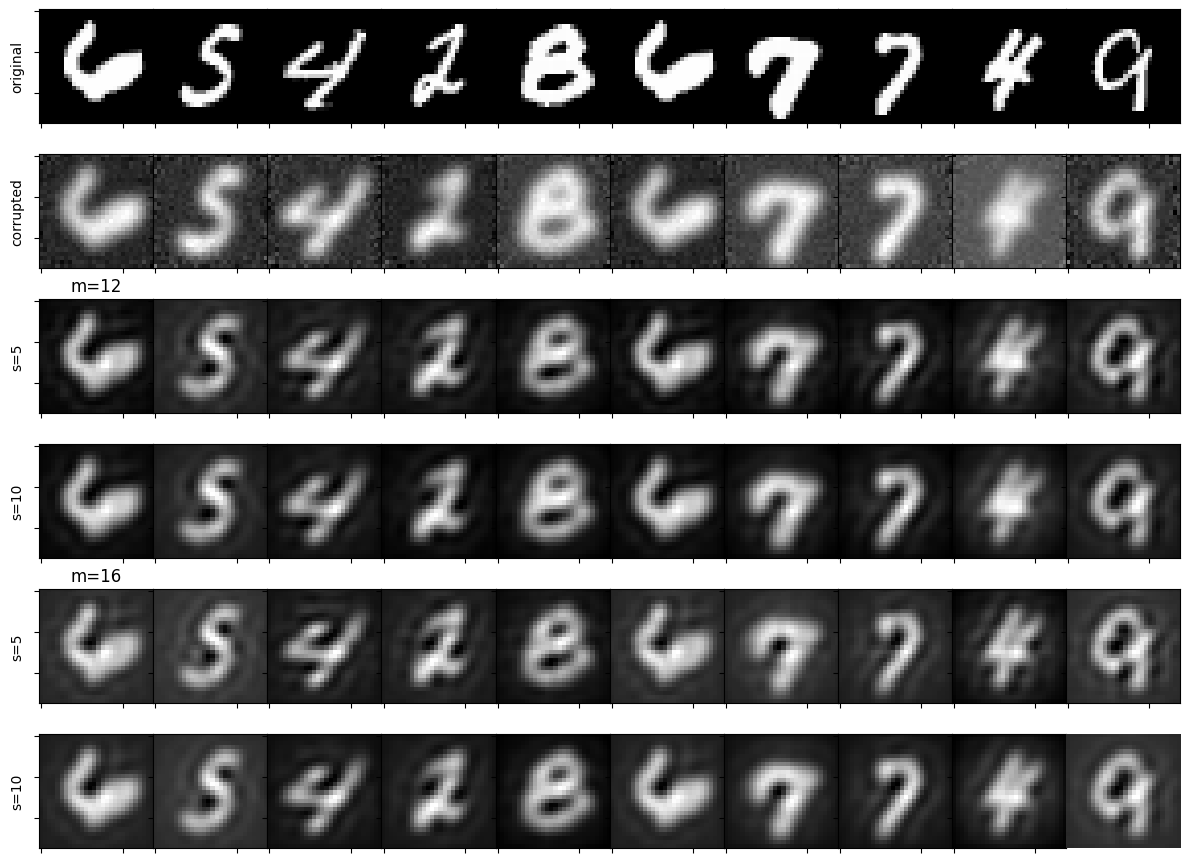

In [159]:
n_images = 10
n_samples = 200
n = 20

distance = np.zeros((2, n_images))
fig, axes = plt.subplots(6, n_images, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(12,9))
idx = np.random.randint(0, len(all_images), (n_images,))

axes[0,0].set_ylabel('original')
axes[1,0].set_ylabel('corrupted')

ms = [12, 16]
sigs = [5, 10]

all_images = load_images(f'./Dataset/MNIST-m={12}/MNIST/corrupted/')
all_originals = load_images(f'./Dataset/MNIST-m={12}/MNIST/original/')


for i, m in enumerate(ms):

    gm = gm_by_m_accurate[i]
    W = np.load(f'Dataset/MNIST-m={m}/MNIST/W.npy')

    axes[(i + 1) * 2, 0].set_title(f'm={m}')

    for x, id in enumerate(idx):
        image       =   all_images[id, :, :]
        original    =   all_originals[id, :, :]
        original   /=   np.max(original)

        if i == 0:
            axes[0, x].imshow(original, cmap='gray')
            axes[1, x].imshow(image, cmap='gray')

        test_data = extract_patch(image.reshape((1, 28, 28)), m=m)

        for k, sig in enumerate(sigs):


            mapResult   =  [res.reshape((m,m)) for res in Z_Y(gm, test_data, W, sig, m, n).T]
            remaked_map = remake_image(mapResult, m)
            remaked_map = remaked_map / np.max(remaked_map)
            axes[2 * (i + 1) + k, x].imshow(remaked_map, cmap='gray')

            if x == 0:
                axes[2 * (i + 1) + k, 0].set_ylabel(f's={sig}')


for i in axes.flatten():
    i.set_xticklabels([])
    i.set_yticklabels([])

fig.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()

In [63]:
n_samples = 200
m = 16

gm_by_n = []

for i, n in enumerate([10,20,30,40,50,60,70,80]):

    gm = train(n_samples, m, n)
    gm_by_n.append(gm)



samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 23.10537s	 ll change 1.33410
  Iteration 20	 time lapse 21.42056s	 ll change 0.07199
Initialization converged: True	 time lapse 59.45604s	 ll -805.64735
samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 44.89586s	 ll change 3.07756
  Iteration 20	 time lapse 42.71876s	 ll change 0.89503
  Iteration 30	 time lapse 40.89085s	 ll change 0.21946
Initialization converged: True	 time lapse 156.74784s	 ll -706.35004
samples of each label:
 [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Initialization 0
  Iteration 10	 time lapse 65.84534s	 ll change 5.48537
  Iteration 20	 time lapse 56.99647s	 ll change 0.18916
  Iteration 30	 time lapse 55.88828s	 ll change 0.46679
  Iteration 40	 time lapse 56.19531s	 ll change 0.01772
Initialization converged: True	 time lapse 263.13124s	 ll -655.42264
samples of each label:
 [20. 20. 20. 20. 

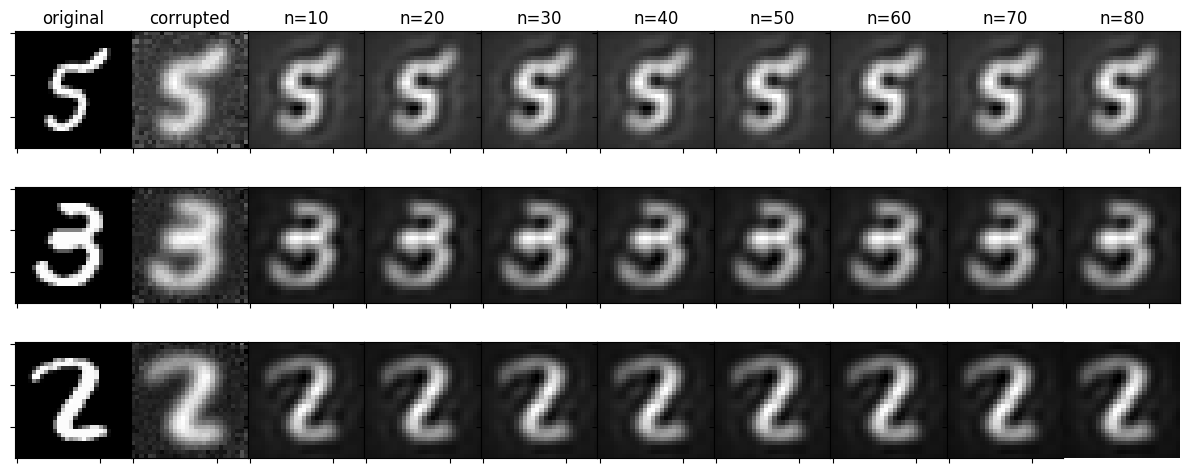

In [160]:
n_samples = 200
n_images = 3
m = 16

W = np.load(f'Dataset/MNIST-m={m}/MNIST/W.npy')
all_images = load_images(f'./Dataset/MNIST-m={m}/MNIST/corrupted/')
all_originals = load_images(f'./Dataset/MNIST-m={m}/MNIST/original/')

fig, axes = plt.subplots(n_images, 10, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(12,5))
idx = np.random.randint(0, len(all_images), (n_images,))

axes[0,0].set_title('original')
axes[0,1].set_title('corrupted')


for i, n in enumerate([10,20,30,40,50,60,70,80]):

    axes[0,i + 2].set_title(f'n={n}')

    gm = gm_by_n[i]

    for j, id in enumerate(idx):
        image       =   all_images[id, :, :]
        original    =   all_originals[id, :, :]
        original   /=   np.max(original)

        if i == 0:
            axes[j, 0].imshow(original, cmap='gray')
            axes[j, 1].imshow(image, cmap='gray')

        test_data = extract_patch(image.reshape((1, 28, 28)), m=m)

        try:
            mapResult   =  [res.reshape((m,m)) for res in Z_Y(gm, test_data, W, 5, m, n).T]
        except Exception:
            mapResult   =  [np.zeros((m,m)) for i in range(len(test_data))]

        remaked_map = remake_image(mapResult, m)
        remaked_map = remaked_map / np.max(remaked_map)
        axes[j, i + 2].imshow(remaked_map, cmap='gray')

for i in axes.flatten():
    i.set_xticklabels([])
    i.set_yticklabels([])

fig.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()

In [65]:
n_samples = 1000
n = 35

finalgm16 = train(n_samples, 16, n)
finalgm12 = train(n_samples, 12, n)

beep()

samples of each label:
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Initialization 0
  Iteration 10	 time lapse 414.65537s	 ll change 3.13537
  Iteration 20	 time lapse 368.79570s	 ll change 0.41741
  Iteration 30	 time lapse 367.18938s	 ll change 0.40888
  Iteration 40	 time lapse 386.83784s	 ll change 0.40327
  Iteration 50	 time lapse 363.03146s	 ll change 0.02515
  Iteration 60	 time lapse 366.45187s	 ll change 0.00762
Initialization converged: True	 time lapse 2589.52632s	 ll -604.14419
samples of each label:
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Initialization 0
  Iteration 10	 time lapse 321.07120s	 ll change 2.97011
  Iteration 20	 time lapse 297.31799s	 ll change 0.70623
  Iteration 30	 time lapse 294.40400s	 ll change 0.43817
  Iteration 40	 time lapse 295.80835s	 ll change 0.08725
  Iteration 50	 time lapse 295.16703s	 ll change 0.14326
  Iteration 60	 time lapse 294.52506s	 ll change 0.02421
  Iteration 70	 time lapse 292.77180s	 ll change 0.30346
Ini

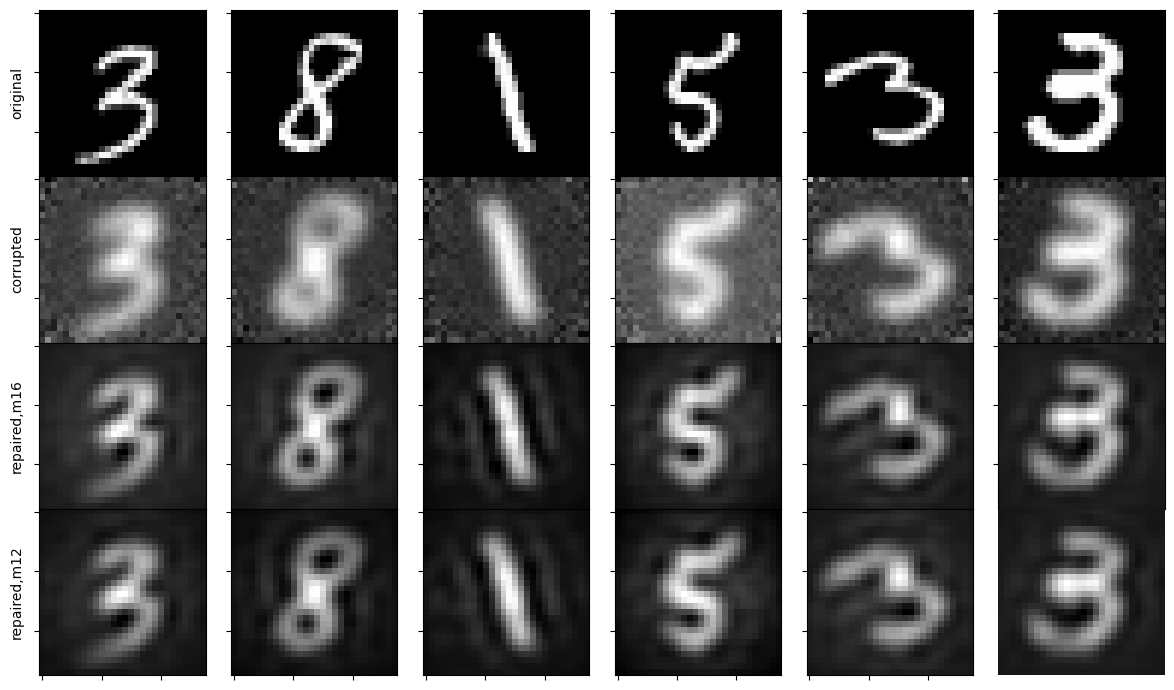

In [161]:
W12 = np.load(f'Dataset/MNIST-m={12}/MNIST/W.npy')
W16 = np.load(f'Dataset/MNIST-m={16}/MNIST/W.npy')
all_images = load_images(f'./Dataset/MNIST-m={16}/MNIST/corrupted/')
all_originals = load_images(f'./Dataset/MNIST-m={16}/MNIST/original/')

n_images = 6
fig, axes = plt.subplots(4, n_images, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(12,7))
idx = np.random.randint(0, len(all_images), (n_images,))

for j, id in enumerate(idx):
        image       =   all_images[id, :, :]
        original    =   all_originals[id, :, :]
        original   /=   np.max(original)

        axes[0, j].imshow(original, cmap='gray')
        axes[1, j].imshow(image, cmap='gray')

        test_data16 = extract_patch(image.reshape((1, 28, 28)), m=16)
        test_data12 = extract_patch(image.reshape((1, 28, 28)), m=12)

        mapResult16   =  [res.reshape((16,16)) for res in Z_Y(finalgm16, test_data16, W16, 5, 16, 35).T]
        mapResult12   =  [res.reshape((12,12)) for res in Z_Y(finalgm12, test_data12, W12, 5, 12, 35).T]

        remaked_map16 = remake_image(mapResult16, 16)
        remaked_map16 = remaked_map16 / np.max(remaked_map16)
        axes[2, j].imshow(remaked_map16, cmap='gray')

        remaked_map12 = remake_image(mapResult12, 12)
        remaked_map12 = remaked_map12 / np.max(remaked_map12)
        axes[3, j].imshow(remaked_map12, cmap='gray')

axes[0,0].set_ylabel('original')
axes[1,0].set_ylabel('corrupted')
axes[2,0].set_ylabel('repaired,m16')
axes[3,0].set_ylabel('repaired,m12')
for i in axes.flatten():
    i.set_xticklabels([])
    i.set_yticklabels([])

fig.tight_layout()
plt.grid(False)
plt.axis('off')
plt.show()